## Getting ready to run the notebook:

To run this notebook, you'll need the crossover files that Denis has been generating.  Put all of the tar.gz files in a directory and untar them ('tar zxvf _file_' for each file), which will make a series of cycle directories (c01, c02, etc).  Each will contain the hdf5 files with the crossover data, which are in 100-km bins, named E(xxx)N_(yyy).h5, where (xxx) and (yyy) are the polar-stereographic coordinates of the bin centers.  Put the location of the top directory in the next cell, in the 'xover_base' variable.  

You'll also need the pointCollection library, which you can download from github:

Run this in a terminal:

git clone git@github.com:SmithB/pointCollection.git;  cd pointCollection; pip install -e . --user



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import scipy.sparse as sp
import re
import glob
colors={1: 'crimson', 2:'hotpink', 3:'green', 4:'limegreen', 5:'dodgerblue', 6:'turquoise' }
tile_re=re.compile('E(.*)_N(.*).h5')


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib notebook

## Set parameter values, file locations here:

In [4]:
xover_base='/Volumes/ice3/ben/ATL06/xovers/Antarctic/r005'
# define all time values, in 10-day increments between 2018 and 2022
delta_t=10*24*3600
t_centers=np.arange(0.75*24*3600*365, (2022-2018)*24*3600*365, delta_t/2)

In [9]:
def RDE(x):
    xs=x.copy()
    xs=np.isfinite(xs)   # this changes xs from values to a boolean
    if np.sum(xs)<2 :
        return np.nan
    ind=np.arange(0.5, np.sum(xs))
    LH=np.interp(np.array([0.16, 0.84])*np.sum(xs), ind, np.sort(x[xs]))
    #print('LH =',LH)
    return (LH[1]-LH[0])/2.  # trying to get some kind of a width of the data ~variance


In [10]:
def read_xovers(file, fields=['x','y','delta_time','h_li','h_li_sigma','h_mean','spot', 'rgt', 'dh_fit_dx','dh_fit_dy','atl06_quality_summary', 'latitude']):
    '''
    Read crossovers from a saved crossover file
    
    Inputs :
    File (str): hdf-5 file to read
    fields (list of strs): fields to read from the file
    
    Returns:
    v (pc.data) field values interpolated to the crossover location
    d (pc.data) Differences between the interpolated field values 
    m (pc.data) Metadata fields for each crossover location, including grounded status, slope, and location
    data (list of pc.data objects) raw data read from each crossover file
    '''
    m = pc.data().from_h5(file, field_dict={None:['grounded','x','y','slope_x','slope_y']})
    v=pc.data(columns=2)
    data = [pc.data(columns=2).from_h5(file, field_dict={group:fields+['W']}) for group in ['data_0','data_1']]
    
    # get ascending-vs-descending status
    asc=np.zeros([m.x.shape[0],2])
    for ii, data_i in enumerate(data):
        asc[:,ii] = data_i.latitude[:,1] > data_i.latitude[:,0]
    
    m.assign({'asc_minus_desc': (asc[:,0]==0) & (asc[:,1]==1)})
    m.assign({'desc_minus_asc': (asc[:,0]==1) & (asc[:,1]==0)})
    
    d=pc.data()
    for field in fields:
        if field=='W':
            continue
        temp = np.zeros((m.size, 2))
        for col in [0, 1]:
            temp[:, col] = np.sum(data[col].W * getattr(data[col], field), axis=1)
        
        if field in ['rgt','cycle','spot']:
            # integer fields:
            v.assign({ field : np.round(temp).astype(int)})
        else:
            v.assign({ field : temp})
            
        d.assign({ field : np.diff(temp, axis=1)})
    for item in [v, d]:
        item.__update_size_and_shape__()
    
    return v, d, m, data

In [11]:
def filter_xovers(v, d, m, data, asc_minus_desc=None):
    '''
    Filter the crossovers based on field values
    '''

    good=np.all(v.atl06_quality_summary < 0.01, axis=1)
    for di in data:
        good &= np.abs(di.delta_time[:,1]-di.delta_time[:,0]) < 0.005
    good &= m.grounded > 0.99
    good &= np.all(np.abs(np.c_[v.dh_fit_dx, v.dh_fit_dy])< 0.2, axis=1)
    
    if asc_minus_desc is not None:
        good &= (m.asc_minus_desc == asc_minus_desc)
    
    v.index(good)
    d.index(good)
    m.index(good)
    for di in data:
        di=di[good]


A Crossover difference provides the information:
$$
    z(r_{i}, s_{k})-z(r_{j}, s_{l}) + \epsilon = \delta_{ijkl}
$$
Here $r_{i}$ and $r_{j}$ are the two RGTs in the crossover, and $s_{k}$ and $s_{l}$ are the spots.

Assuming that the temporal change in the surface is small, we can decompose this to
$$
    b_{ri}-b_{rj} + b{sk}-b{sl} + \epsilon = \delta{ijlk}
$$
A set of crossovers from different rgts and spots gives us information about the relative bias differences between the spots and between the rgts.  Below, we build a set of matrix equations that describes the spot and rgt biases for a collection of crossovers, and solves for the relative spot and rgt biases (the spot biases are relative to the mean of the spot biases, the rgt biases are relative to the mean of the rgt biases).


In [12]:
def calc_biases(d, v, ind):
    '''
    Calculate per-rgt and per-spot biases based on a set of crossover data
    Inputs:
        d (pc.data) Differences between the interpolated field values 
        v (pc.data) field values interpolated to the crossover location
        ind (numpy array) Indices of crossovers that should be included in the calculation
    
        Note the d and v are assumed to represent crossovers within a single cycle
    Returns:
        b_spot (numpy array) : Estimated bias for each spot (first entry corresponds to spot 1, etc)
        b_rgt (numpy array) : Estimated bias for each rgt (first entry corresponds to rgt 1, etc)
        sigma_hat (float) : robust misfit between the h_li differences and the bias model
        sigma_corr (float) : standard devlation between h_li and the bias model
        sigma_unc (float) : standard deviation between h_mean and the bias model
        N_spot (numpy array) : Number of data contributing to the estimate for each spot
        N_rgt (numpy array) : Number of data contributing to the estimate for each rgt.
    '''
    
    # select the data to process
    v1=v[ind]
    d1=d[ind]

    #Make indexes for unique spot and rgt values
    uS, iS=np.unique(v1.spot, return_inverse=True)
    uT, iT=np.unique(v1.rgt,  return_inverse=True)
    row=np.arange(v1.shape[0])
    # make a matrix that calculates the bias for each data point when multiplied by a set of spot biases
    G_sp=sp.coo_matrix((np.c_[-np.ones(v1.shape[0]), np.ones(v1.shape[0])].ravel(),(np.c_[row, row].ravel(), iS.ravel())))
    # make a matrix that calculates the bias for each data point when multiplied by a set of rgt biases
    G_rgt=sp.coo_matrix((np.c_[-np.ones(v1.shape[0]), np.ones(v1.shape[0])].ravel(),(np.c_[row, row].ravel(), iT.ravel())))
    # make a constraint matrix for the mean of all spot biases
    G_sp_mean=sp.coo_matrix((np.r_[np.ones(len(uS)), np.zeros(len(uT))],
                              (np.zeros(len(uS)+len(uT), dtype=int), 
                                np.arange(len(uS)+len(uT), dtype=int)))) 
    # make a constraint matrix for the mean of all rgt biases
    G_rgt_mean=sp.coo_matrix((np.r_[np.zeros(len(uS)), np.ones(len(uT))],
                              (np.zeros(len(uS)+len(uT), dtype=int), 
                                np.arange(len(uS)+len(uT), dtype=int)))) 

    # put all the matrices together into one sparse matrix
    G=sp.vstack([sp.hstack([G_sp, G_rgt]), G_sp_mean, G_rgt_mean, 0.0001*sp.eye(len(uS)+len(uT))])
    G=G.tocsr()
    #make a data vector of height (h_li) differences
    data=np.r_[d1.h_li.ravel(), np.zeros(G.shape[0]-d1.shape[0])]
    r=np.zeros(d1.shape[0])
    good=np.ones(G.shape[0], dtype=bool)
    # initialize book-keeping variables
    last_good=np.zeros_like(good)
    sigma=1.e4
    n_data=d1.shape[0]
    count = 0
    # iterate to remove outliers
    while np.sum(np.logical_xor(good,last_good))>0 and (count < 20):
        count += 1
        ii=np.flatnonzero(good)
        mm=sp.linalg.spsolve(G[ii,:].T.dot(G[ii,:]), G[ii,:].T.dot(data[ii]))
        r=d1.h_li.ravel()-G[0:d1.size,:].dot(mm)
        sigma_hat=RDE(r[ii[ii<n_data]])
        last_good=good
        good=np.ones(G.shape[0], dtype=bool)
        good[np.argwhere(np.abs(r)>3*sigma_hat)]=False
    
    r_temp=r[ii[ii<n_data]]
    # estimate the variance in the corrected data (including the full corrections in h_li)
    sigma_corr = np.sqrt(np.sum(r_temp**2)/(len(r_temp)-G.shape[1]))
    
    # estimate the variance in the uncorrected data (using only h_mean)
    data_unc = np.r_[d1.h_mean.ravel(), np.zeros(G.shape[0]-d1.shape[0])]
    m_unc = sp.linalg.spsolve(G[ii,:].T.dot(G[ii,:]), G[ii,:].T.dot(data_unc[ii]))
    r_unc = d1.h_mean.ravel()-G[0:d1.size,:].dot(m_unc)
    r_unc=r_unc[ii[ii<n_data]]
    sigma_unc = np.sqrt(np.sum(r_unc**2)/(len(r_unc)-G.shape[1]))

    # map the solution to the output variables
    # one b_spot and n_spot for each spot
    b_spot=np.zeros(6)+np.NaN
    b_spot_unc=np.zeros(6)+np.NaN
    N_spot=np.zeros(6)
    
    for ind,spot in enumerate(uS):
        b_spot[int(spot)-1]=mm[ind]
        b_spot_unc[int(spot)-1]=m_unc[ind]
        N_spot[int(spot)-1]=np.sum(np.abs(G[:,spot][ii]))-1
    # one b_rgt and N_rgt for each rgt
    b_rgt = np.zeros(1387)+np.NaN
    N_rgt = np.zeros(1387)+np.NaN
    for ind, rgt in enumerate(uT):
        b_rgt[int(rgt)-1]=mm[len(uS)+ind]
        N_rgt[int(rgt)-1]=np.sum(np.abs(G[:,len(uS)+ind][ii]))-1 
    return b_spot, b_rgt, b_spot_unc, sigma_hat, sigma_corr, sigma_unc, N_spot, N_rgt

We will run this analysis separately for nine 400x400-km regions near the Antarctic pole hole, to check whether the per-spot biases are the same for independent sets of tracks.

<IPython.core.display.Javascript object>


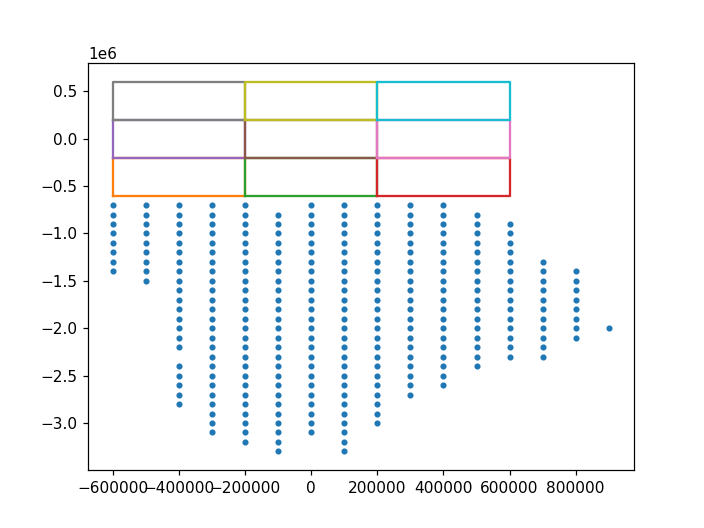

In [13]:
# define the region centers:
spacing=4.e5
x0, y0 = np.meshgrid(np.arange(-spacing, 2*spacing, spacing), np.arange(-spacing, 2*spacing, spacing))

# map the bin center locations (for cycle 1, but they should be mostly all the same)
cycle=1
files=glob.glob(xover_base+f'/c{cycle:02d}/E*.h5')
xy=np.c_[[[int(xx) for xx in tile_re.search(file).groups()] for file in files]]
plt.figure(); plt.plot(xy[:,0], xy[:,1],'.')

#map the region locations
for xi, yi in zip(x0.ravel(), y0.ravel()):
    plt.plot(xi+ np.array([-1, 1, 1, -1, -1])*spacing/2, yi+ np.array([-1, -1, 1, 1, -1])*spacing/2)


To chart the time evolution of the spot biases, we run the analysis separately for overlapping 20-day time increments.

In [14]:
def get_spot_biases(xover_base, x0, y0, spacing, all_t, dt=10*24*3600, asc_minus_desc=None):
    '''
    Process a collection of crossover files to give time-varying biases
    
    Inputs:
    xover_base (str) : directory containing the crossover subdirectories (c01 for cycle 1, etc)
    x0, y0 (numpy arrays) : bin centers to read 
    spacing (numeric): bin sizes
    all_t (numpy array): centers of the time windows for which to calculate the biases
    dt (numeric): range of times around each time window center to include in each bias calculation
    asc_minus_desc (numeric): optional argument specifying whether to process ascending-minus_descending (1),
        descending-minus-ascending(0), or both (None, default)
    Outputs:
    spot_biases (dict) : One set of spot biases (6 x N_times array) for each location and cycle
    times (dict) : one set of time values for each location and cycle
    counts (dict) : one set of per-spot counts for each location and cycle
    sigma_hats (dict) : one set of per-spot residual robust spreads (h_li differences) for each location and cycle
    sigma_corrs (dict) : one set of per-spot residual standard deviations (h_li differences) for each location and cycle)
    sigma_uncs (dict) : one set of per-spot residual standard deviations (h_mean differences) for each location and cycle)
    '''
    spot_biases={}
    times={}
    tile_re=re.compile('E(.*)_N(.*).h5')
    spot_biases, spot_biases_unc, times, counts, sigma_hats, sigma_corrs, sigma_uncs=[{}, {}, {}, {}, {}, {}, {}]
    for xi, yi in zip(x0.ravel(), y0.ravel()):
        loc=(xi, yi)
        print(f"working on tile {loc}")
        spot_biases[loc], spot_biases_unc[loc], times[loc], counts[loc], sigma_hats[loc], sigma_corrs[loc], sigma_uncs[loc] = [{}, {}, {}, {}, {}, {}, {}]
        for cycle in range(1, 14):
            print(f'\t cycle={str(cycle)}')
            files=glob.glob(xover_base+f'/c{cycle:02d}/E*.h5')
            v, d, m = [[], [], []]
            for file in files:
                try:
                    xy=np.c_[[int(xx) for xx in tile_re.search(file).groups()]]
                    if (xy[0] <= xi-spacing/2) | (xy[0] > xi+spacing/2) | \
                        (xy[1] <= yi-spacing/2) | (xy[1] > yi+spacing/2):
                        continue
                    vv, dd, mm, DD = read_xovers(file)
                    filter_xovers(vv, dd, mm, DD, asc_minus_desc=asc_minus_desc)
                    v += [vv]
                    d += [dd]
                    m += [mm]
                except Exception as e:
                    pass
            v=pc.data(columns=2).from_list(v)
            d=pc.data().from_list(d)
            m=pc.data().from_list(m)
            t_ind=np.flatnonzero((all_t >= np.min(v.delta_time)) & (all_t <= np.max(v.delta_time)))
            t_vals=all_t[t_ind]
            b_spot=np.zeros((len(t_vals), 6))+np.NaN
            b_spot_unc=np.zeros((len(t_vals), 6))+np.NaN
            b_rgt=np.zeros((len(t_vals), 1387))+np.NaN
            N_rgt=np.zeros((len(t_vals), 1387))+np.NaN
            sigma_hat=np.zeros(len(t_vals))+np.NaN
            sigma_unc=np.zeros(len(t_vals))+np.NaN
            sigma_corr=np.zeros(len(t_vals))+np.NaN
            N_spot=np.zeros((len(t_vals), 6))+np.NaN
            for it, ti in enumerate(t_vals):
                ii = np.all(np.abs(v.delta_time-ti)<dt/2, axis=1)
                if np.sum(ii)>10:
                    b_spot[it,:], b_rgt[it,:], b_spot_unc[it,:], sigma_hat[it], sigma_corr[it], sigma_unc[it],  N_spot[it,:], N_rgt[it, :]=calc_biases(d, v, np.argwhere(ii))
            spot_biases[loc][cycle]=b_spot
            spot_biases_unc[loc][cycle]=b_spot_unc
            times[loc][cycle]=t_vals
            counts[loc][cycle]=N_spot
            sigma_hats[loc][cycle]=sigma_hat
            sigma_uncs[loc][cycle]=sigma_unc
            sigma_corrs[loc][cycle]=sigma_corr
    return spot_biases, spot_biases_unc, times, counts, sigma_hats, sigma_corrs, sigma_uncs

The results (for today) are a set of biases for each 400x400-km area and each 20-day time increment.  Plotting the biases separately shows that the biases are roughly the same between the different areas:

In [ ]:
spot_biases, spot_biases_unc, times, count, sigma_hats, sigma_corrs, sigma_uncs = get_spot_biases(xover_base, x0, y0, spacing, t_centers, dt=10*24*3600)

In [ ]:
hf, hax=plt.subplots(3,3, figsize=[7,6], sharex=True, sharey=True)
spots=range(1,7)
colors={spot:None for spot in spots}
colors={1:'blue', 2:'cyan', 3:'red', 4:'magenta', 5:'green', 6:'olive'}
for count, loc in enumerate( zip(x0.ravel(), y0[::-1].ravel())):
    plt.sca(hax.ravel()[count])
    if loc not in spot_biases:
        continue
    for cycle in spot_biases[loc].keys():
        for spot in range(1,7):
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, spot_biases[loc][cycle][:, spot-1], color=colors[spot])
            #if colors[spot] is None:
                #colors[spot]=h_line[0].get_color()
            if cycle==1:
                h_line[0].set_label(f'spot {spot}')

plt.tight_layout()              
#for ii in range(4):
#    for jj in range(4):
#        if jj>0:
#            hax[ii, jj].set_yticks([])
#        if ii < 2:
#            hax[ii, jj].set(xtics)
plt.legend()

Plotting the biases on the same axes shows that the time variation is not significantly different (at the mm level) between the regions.

In [ ]:
hf, hax=plt.subplots(1,1, figsize=[8,6])
spots=range(1,7)
colors={spot:None for spot in spots}
for count, loc in enumerate( zip(x0.ravel(), y0[::-1].ravel())):
    for cycle in spot_biases[loc].keys():
        for spot in range(1,7):
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, spot_biases[loc][cycle][:, spot-1], color=colors[spot])
            if colors[spot] is None:
                colors[spot]=h_line[0].get_color()
                h_line[0].set_label(f'spot {spot}')
plt.legend()

plt.gca().set_xlabel('year')
plt.gca().set_ylabel('Spot bias - mean, m')

## Export spot-by-spot data as a csv:

In [ ]:
spots=range(1,7)
locs=list(zip(x0.ravel(), y0[::-1].ravel()))
cycles=spot_biases[locs[0]].keys()

loc_times={loc:np.concatenate([times[loc][cycle] for cycle in cycles], axis=0) for loc in locs}
loc_biases={loc:np.concatenate([spot_biases[loc][cycle] for cycle in cycles], axis=0) for loc in locs}

all_times =np.unique(np.concatenate([loc_times[loc][:,None] for loc in locs], axis=0))

all_biases=np.zeros([len(all_times), len(spots), len(locs)])+np.NaN
for loc_i, loc in enumerate(locs):
    _, ind1, ind2 = np.intersect1d(loc_times[loc], all_times, return_indices=True)
    for spot_i in range(6):
        all_biases[ind2, spot_i, loc_i] = loc_biases[loc][ind1, spot_i]
mean_biases=np.nanmean(all_biases, axis=2)

import pandas as pd
temp={'delta_time': all_times}
temp.update({f'spot_{spot}':mean_biases[:,spot_i] for spot_i, spot in enumerate(spots)})
df=pd.DataFrame(temp)
df.to_csv('spot_biases_rel005.csv', index=False)
! pwd

## Extra plots, etc

We also derive the aggregate robust misfit to the least-square solution, which should give an estimate of the errors in the data as a function of time

In [ ]:
hf, hax=plt.subplots(1,1, figsize=[8,6])
spots=range(1,7)
loc_colors={}
for count, loc in enumerate( spot_biases.keys()):#zip(x0.ravel(), y0[::-1].ravel())):
        
    for cycle in spot_biases[loc].keys():
        if loc not in loc_colors:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, sigma_hats[loc][cycle])
            loc_colors[loc]=h_line[0].get_color()
            h_line[0].set_label(str(loc))

        else:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, sigma_hats[loc][cycle], color=loc_colors[loc])
        
plt.gca().set_xlabel('time')
plt.gca().set_ylabel('robust misfit, m')
plt.legend()

### Same Same, but for sigma_corr

In [ ]:
hf, hax=plt.subplots(1,1, figsize=[8,6])
spots=range(1,7)
loc_colors={}
for count, loc in enumerate( spot_biases.keys()):
        
    for cycle in spot_biases[loc].keys():
        if loc not in loc_colors:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, sigma_corrs[loc][cycle])
            loc_colors[loc]=h_line[0].get_color()
            h_line[0].set_label(str(loc))

        else:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, sigma_corrs[loc][cycle], color=loc_colors[loc])


for count, loc in enumerate( spot_biases.keys()):
        
    for cycle in spot_biases[loc].keys():
        if loc not in loc_colors:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, sigma_uncs[loc][cycle], '--')
            loc_colors[loc]=h_line[0].get_color()
            h_line[0].set_label(str(loc))

        else:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, sigma_uncs[loc][cycle],'--', color=loc_colors[loc])
        

plt.gca().set_xlabel('time')
plt.gca().set_ylabel('RMS misfit, m')
plt.legend()
plt.title('solid: h_li, dashed: h_mean' )

In [ ]:
hf, hax=plt.subplots(1,1, figsize=[8,6])
spots=range(1,7)
loc_colors={}
for count, loc in enumerate( spot_biases.keys()):
        
    for cycle in spot_biases[loc].keys():
        correction = np.sqrt(np.maximum(0,sigma_uncs[loc][cycle]**2-sigma_corrs[loc][cycle]**2 ))
        if loc not in loc_colors:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, correction)
            loc_colors[loc]=h_line[0].get_color()
            h_line[0].set_label(str(loc))

        else:
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, correction, color=loc_colors[loc])
plt.gca().set_ylabel('extra error in h_mean')


## Try the same for Greenland

<IPython.core.display.Javascript object>


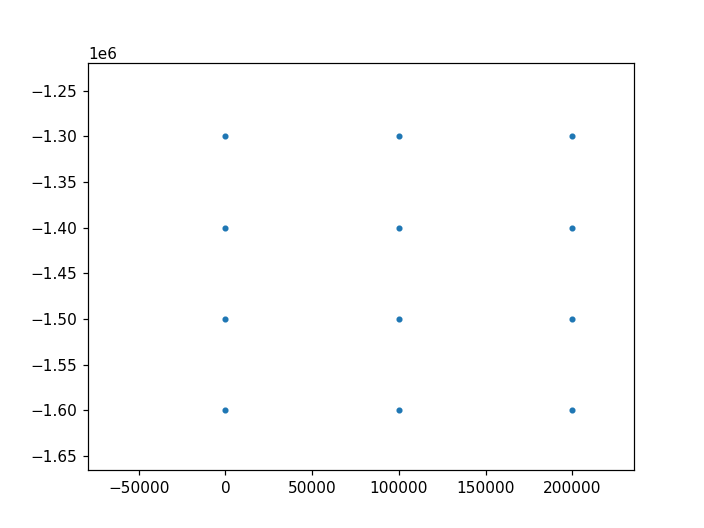

In [7]:
xover_base='/Volumes/ice3/ben/ATL06/xovers/Arctic/r005'
#for cycle in range(1, 14):
cycle=10
files=glob.glob(xover_base+f'/c{cycle:02d}/E*.h5')
xy=np.c_[[[int(xx) for xx in tile_re.search(file).groups()] for file in files]]
plt.figure(); plt.plot(xy[:,0], xy[:,1],'.')

In [18]:
spacing

array([8580000.])

In [21]:
XR=plt.gca().get_xlim()
YR=plt.gca().get_ylim()

spacing=np.diff(plt.gca().get_ylim())
spot_biases_GL, spot_biases_unc_GL, times_GL, count_GL, sigma_hats_GL, sigma_corrs_GL, sigma_uncs_GL = \
    get_spot_biases(xover_base, np.array([np.mean(XR)]), np.array([np.mean(YR)]), spacing, t_centers, dt=10*24*3600)


working on tile (150000.0, -1350000.0)
	 cycle=1
	 cycle=2
	 cycle=3
	 cycle=4
	 cycle=5
	 cycle=6
	 cycle=7
	 cycle=8
	 cycle=9
	 cycle=10
	 cycle=11
	 cycle=12
	 cycle=13


<IPython.core.display.Javascript object>


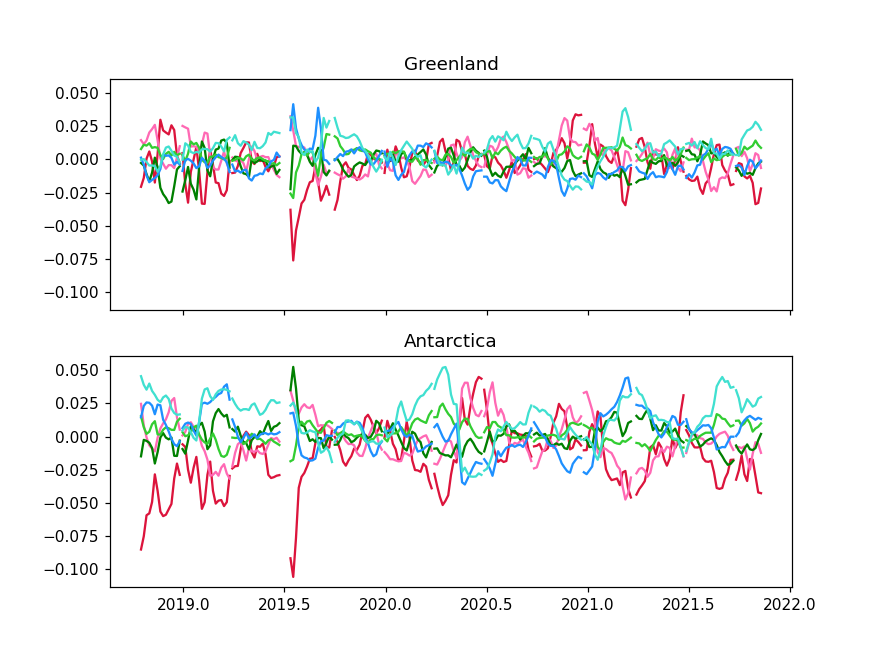

Text(0.5, 1.0, 'Antarctica')

In [31]:
hf, hax=plt.subplots(2,1, figsize=[8,6], sharex=True, sharey=True)



spots=range(1,7)
plt.sca(hax[0])
for count, loc in enumerate( spot_biases_GL.keys()):
    for cycle in spot_biases_GL[loc].keys():
        for spot in range(1,7):
            #h_line=plt.plot(times_GL[loc][cycle]/24/3600/365.25+2018, spot_biases_GL[loc][cycle][:, spot-1], 
            #                'wo')
            h_line=plt.plot(times_GL[loc][cycle]/24/3600/365.25+2018, spot_biases_GL[loc][cycle][:, spot-1], 
                            color=colors[spot])
plt.gca().set_title('Greenland')
            
plt.sca(hax[1])
for count, loc in enumerate( zip(x0.ravel(), y0[::-1].ravel())):
    for cycle in spot_biases[loc].keys():
        for spot in range(1,7):
            h_line=plt.plot(times[loc][cycle]/24/3600/365.25+2018, spot_biases[loc][cycle][:, spot-1], color=colors[spot])
plt.gca().set_title('Antarctica')            
           

In [ ]:
xover_base

In [28]:
y0=np.array([0])
x0=np.array([8.e5])
xover_base='/Volumes/ice3/ben/ATL06/xovers/Antarctic/r005'
spacing=4.e5
spot_biases, spot_biases_unc,  times, count, sigma_hats, sigma_corrs, sigma_uncs = get_spot_biases(xover_base, x0, y0, spacing, t_centers, dt=10*24*3600)

#spot_biases_AD, spot_biases_unc_AD,  times_AD, count_AD, sigma_hats_AD, sigma_corrs_AD, sigma_uncs_AD = \
#    get_spot_biases(xover_base, x0, y0, spacing, t_centers, dt=10*24*3600, asc_minus_desc=1)

#spot_biases_DA, spot_biases_unc_DA, times_DA, count_DA, sigma_hats_DA, sigma_corrs_DA, sigma_uncs_DA = \
#    get_spot_biases(xover_base, x0, y0, spacing, t_centers, dt=10*24*3600, asc_minus_desc=0)


working on tile (800000.0, 0)
	 cycle=1
	 cycle=2
	 cycle=3
	 cycle=4
	 cycle=5
	 cycle=6
	 cycle=7
	 cycle=8
	 cycle=9
	 cycle=10
	 cycle=11
	 cycle=12
	 cycle=13


In [ ]:
xyi  =(800000.0,0.)
cycles=np.arange(1., 13.)
spots=range(1,7)
plt.figure()

for tt, spb, style in zip([times, times_AD, times_DA], [spot_biases, spot_biases_AD, spot_biases_DA], ['-','--',':']):
    for cycle in cycles:
        for spot in spots:
            hl=plt.plot(tt[xyi][cycle]/24/3600/365.25+2018, spb[xyi][cycle][:, spot-1], color=colors[spot], linestyle=style)
            #colors[spot]=hl[0].get_color()

In [ ]:
plt.figure()
xyi  =(800000.0,0.)
cycles=np.arange(1., 13.)
spots=range(1,7)
for tt, spb, style in zip([times, times], [spot_biases_unc, spot_biases], ['-',':']):
    for cycle in cycles:
        for spot in spots:
            hl=plt.plot(tt[xyi][cycle]/24/3600/365.25+2018, spb[xyi][cycle][:, spot-1], color=colors[spot], linestyle=style)
            colors[spot]=hl[0].get_color()